# Face Mask Detection Using Inception V3
Applying Image Processing concepts and using Inception V3 as the neural network architecture to detect the right labels (mask or non mask) for the images of the <b> Covid Face Mask Detection Dataset

##  Imports for the project

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import pathlib
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
import itertools

## Retrieve the files' location on local machine

In [4]:
current_dir = os.getcwd()
for dirname, _, filenames in os.walk(current_dir):
    for filename in filenames:
        os.path.join(dirname, filename)
        break

 Set variables train_dir, val_dir and test_dir to the respective files on computer

In [5]:
train_dir=os.path.join(current_dir,"train")
val_dir=os.path.join(current_dir,"validation")
test_dir=os.path.join(current_dir,"test")

## Set up 
A directory path to a folder named "train" and load the list of class names for the images within that folder.

In [6]:
data_dir = os.path.join(current_dir,"train")
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img 
class_names=os.listdir(data_dir)
print(data_dir)
print(class_names)

C:\Users\Admin\Documents\githubRepo\COMP478\COMP478_Project\train
['Mask', 'Non Mask']


## Present Dataset 
A random image from a given target directory and target class and repeat the process 12 times, printing the shape of the image each time it is displayed.

Image shape: (1200, 902, 3)
Image shape: (417, 624, 3)
Image shape: (428, 320, 3)
Image shape: (428, 320, 3)
Image shape: (248, 203, 3)
Image shape: (416, 301, 3)
Image shape: (428, 320, 3)
Image shape: (500, 1208, 3)
Image shape: (938, 720, 3)
Image shape: (683, 1024, 3)
Image shape: (900, 1600, 3)
Image shape: (480, 910, 3)
Image shape: (480, 910, 3)


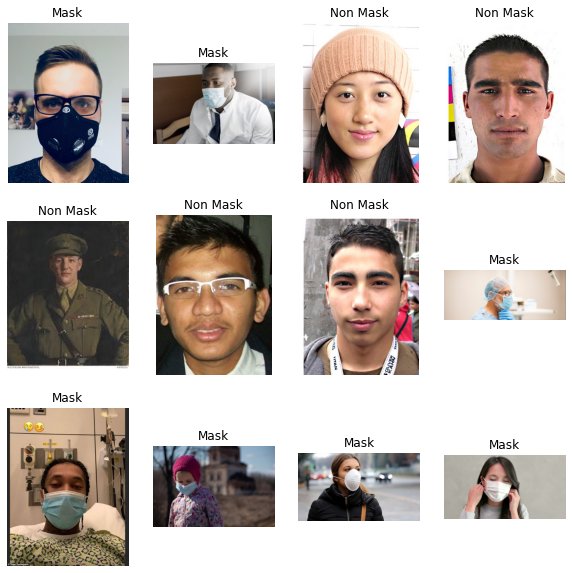

In [7]:
def view_random_image(target_dir, target_class):
    target_folder = os.path.join(data_dir,target_class)
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}")
    return img
import random
plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    r=random.randint(0,1)
    img = view_random_image(data_dir, class_names[r])    
print(f"Image shape: {img.shape}")

## Set Hyperparameter values for the model
Set the seed, specify the image size, batch size, and validation split, then load and preprocess image datasets from three directories, specifying categorical labels and using the previously defined settings.

In [8]:
SEED = 0
# Size of the images is initially (128,128)
IMAGE_SIZE = (224, 224)
# Default batch size
BATCH_SIZE = 32
# Images are grayscale
# 20% test split
VAL_SPLIT = 0.2

tf.random.set_seed(SEED)
np.random.seed(SEED)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 600 files belonging to 2 classes.
Found 306 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


## Perform Data Augmentation
Create two Sequential models: resize_and_rescale and data_augmentation, and then apply the data_augmentation model to the training data using the map() function.

In [31]:
from tensorflow.keras import models,layers

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2,0.3),

])

train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Classification Model
Build a classification model using transfer learning from the InceptionV3 model and compile it with a categorical cross-entropy loss and the Adam optimizer.

In [33]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import applications

base_model =applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False
model_Inc = Sequential(resize_and_rescale)
model_Inc.add(base_model)
model_Inc.add(GlobalAveragePooling2D())
model_Inc.add(Dropout(0.5))
model_Inc.add(Dense(64, 
                    activation='linear'))
model_Inc.add(Dense(2, 
                    activation='softmax'))
model_Inc.build(input_shape=(32,224,224,3))

model_Incep = model_Inc
LR = 0.001

model_Incep.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
                metrics=["accuracy"])

In [34]:
model_Incep.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (32, 2048)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (32, 2048)                0         
                                                                 
 dense_2 (Dense)             (32, 64)                  131136    
                                                                 
 dense_3 (Dense)             (32, 2)                   130       
                                                      

In [35]:
import tensorflow as tf
tf.keras.utils.plot_model(model_Incep,to_file='model_Incep.png',show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Train the model_Incep neural network model using the train_data dataset, and validate the model using the valid_data dataset for 15 epochs, while printing the training progress

In [36]:
EPOCHS = 15
history = model_Incep.fit(train_data,
                      validation_data=valid_data,
                      epochs=EPOCHS,
                      verbose=True
                      )

Epoch 1/15
19/19 [==============================] - 74s 3s/step - loss: 0.6442 - accuracy: 0.7917 - val_loss: 0.0813 - val_accuracy: 0.9641
Epoch 2/15
19/19 [==============================] - 56s 3s/step - loss: 0.4539 - accuracy: 0.8650 - val_loss: 0.1331 - val_accuracy: 0.9510
Epoch 3/15
19/19 [==============================] - 56s 3s/step - loss: 0.2487 - accuracy: 0.9283 - val_loss: 0.0954 - val_accuracy: 0.9608
Epoch 4/15
19/19 [==============================] - 57s 3s/step - loss: 0.1972 - accuracy: 0.9317 - val_loss: 0.0747 - val_accuracy: 0.9673
Epoch 5/15
19/19 [==============================] - 59s 3s/step - loss: 0.2553 - accuracy: 0.9167 - val_loss: 0.1164 - val_accuracy: 0.9477
Epoch 6/15
19/19 [==============================] - 56s 3s/step - loss: 0.2635 - accuracy: 0.9333 - val_loss: 0.1093 - val_accuracy: 0.9542
Epoch 7/15
19/19 [==============================] - 59s 3s/step - loss: 0.1884 - accuracy: 0.9333 - val_loss: 0.1469 - val_accuracy: 0.9444
Epoch 8/15
19/19 [==

In [37]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.644240,0.791667,0.081253,0.964052
1,0.453880,0.865000,0.133091,0.950980
2,0.248742,0.928333,0.095431,0.960784
3,0.197164,0.931667,0.074744,0.967320
4,0.255273,0.916667,0.116419,0.947712
5,0.263456,0.933333,0.109278,0.954248
6,0.188357,0.933333,0.146879,0.944444
7,0.227131,0.928333,0.176575,0.950980
8,0.195262,0.931667,0.119845,0.960784
9,0.371390,0.898333,0.080719,0.967320


## Training Loss and Accuracy Graphs
Plot and visualize the training and validation loss as well as the training and validation accuracy of a model's training history over epochs.

Text(0.5, 1.0, 'Accuracy')

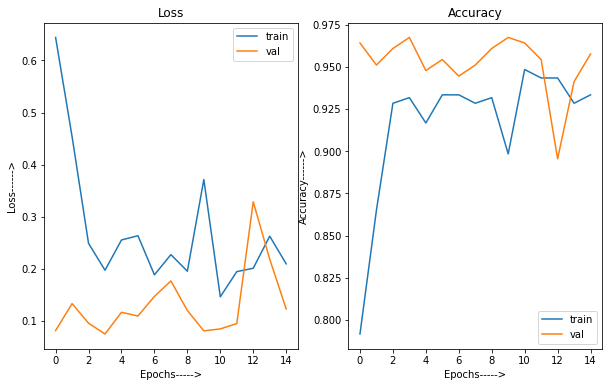

In [38]:
df=pd.DataFrame(history.history)
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(df[['loss','val_loss']])
plt.xlabel("Epochs----->")
plt.ylabel("Loss------>")
plt.legend(['train','val'])
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(df[['accuracy','val_accuracy']])
plt.xlabel("Epochs----->")
plt.ylabel("Accuracy------>")
plt.legend(['train','val'])
plt.title("Accuracy")

In [39]:
model_Incep.evaluate(test_data)

4/4 [==============================] - 7s 1s/step - loss: 0.1312 - accuracy: 0.9800


[0.13124115765094757, 0.9800000190734863]

## Display Predictions
Define a function for predicting image classes with a trained model and use that function to display the predictions alongside the actual classes for a random sample of images from a test dataset

1/1 [==============================] - 0s 80ms/step


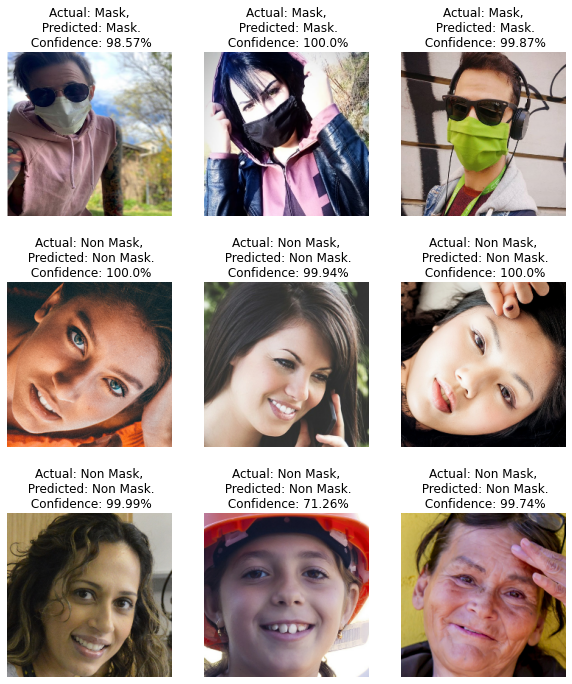

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions)]
    confidence = round(100 * (np.max(predictions)), 2)
    return predicted_class, confidence

import numpy as np
plt.figure(figsize=(10, 12))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_Incep, images[i].numpy())
#         print(labels)
        actual_class = class_names[np.argmax(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [62]:
y_pred=[]
y_actual=[]
for images , labels in test_data:
    label=np.array(labels)
    pred=model_Incep.predict(images)
    for i in pred:
      y_pred.append(np.argmax(i))
    for i in label: 
      y_actual.append(np.argmax(i))

1/1 [==============================] - 0s 188ms/step


## Confusion Matrix
Generate confusion matrix for the model

<AxesSubplot:>

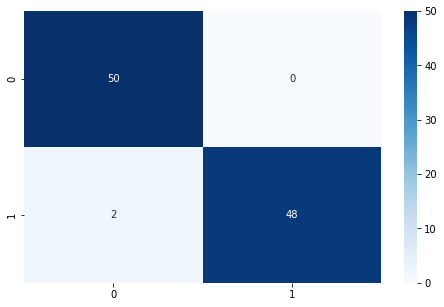

In [63]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_actual,y_pred)
import seaborn as sns
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat,annot=True,cmap="Blues")

## Display Wrong Predictions
Generate a 3x3 grid of images with corresponding labels and confidences where the model's predictions did not match the actual labels from the validation dataset.

1/1 [==============================] - 0s 160ms/step


ValueError: num must be 1 <= num <= 9, not 10

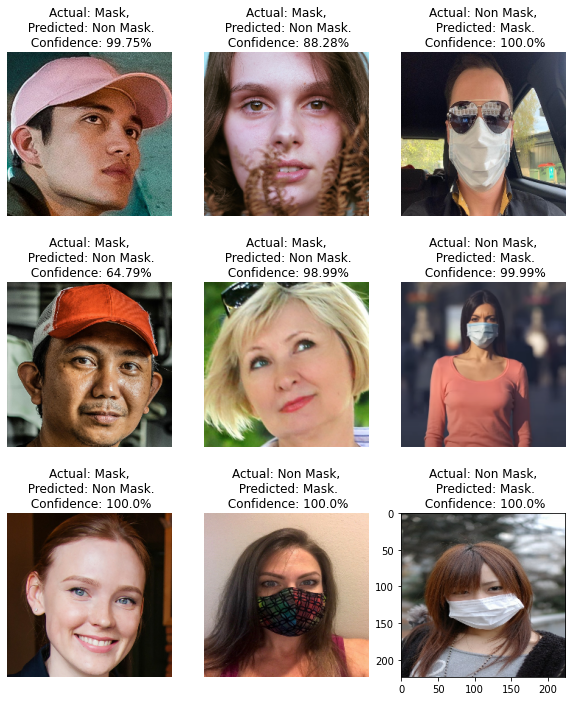

In [80]:
plt.figure(figsize=(10, 12))
k=1
for j in range(1,6):
    for images, labels in valid_data.take(j):
        for i in range(9):
            predicted_class, confidence = predict(model_Incep, images[i].numpy())
    #         print(labels)
            actual_class = class_names[np.argmin(labels[i])] 
            if(predicted_class!=actual_class):
                ax = plt.subplot(3, 3, k)
                k=k+1
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
                if(k==10):
                    break
            plt.axis("off")
            if k > 9:
                break
    if k > 9:
        break

## Classification Report
Generate classification report for the model displaying the accuracy, precision, recall and f1-score measures

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_actual,y_pred,target_names=class_names))

              precision    recall  f1-score   support

        Mask       0.96      1.00      0.98        50
    Non Mask       1.00      0.96      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [73]:
model_Incep.save("model_Incep.h5")

In [74]:
base_model_eff =applications.EfficientNetB7(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model_eff.trainable = False
model_Eff = Sequential(resize_and_rescale)
model_Eff.add(base_model_eff)
model_Eff.add(GlobalAveragePooling2D())
model_Eff.add(Dropout(0.5))
model_Eff.add(Dense(64, 
                    activation='linear'))
model_Eff.add(Dense(2, 
                    activation='softmax'))
model_Eff.build(input_shape=(32,224,224,3))

model_Effic = model_Eff
LR = 0.001

model_Effic.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
                metrics=["accuracy"])

258076736/258076736 [==============================] - 273s 1us/step


In [75]:
model_Effic.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d_2   (32, 2560)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (32, 2560)                0         
                                                                 
 dense_4 (Dense)             (32, 64)                  163904    
                                                                 
 dense_5 (Dense)             (32, 2)                   130       
                                                      

## Display the training loss and accuracy

Text(0.5, 1.0, 'Accuracy')

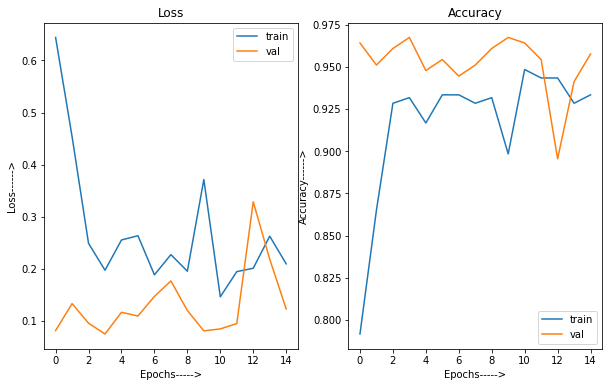

In [76]:
df=pd.DataFrame(history.history)
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(df[['loss','val_loss']])
plt.xlabel("Epochs----->")
plt.ylabel("Loss------>")
plt.legend(['train','val'])
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(df[['accuracy','val_accuracy']])
plt.xlabel("Epochs----->")
plt.ylabel("Accuracy------>")
plt.legend(['train','val'])
plt.title("Accuracy")

In [77]:
y_pred_eff=[]
y_actual_eff=[]
for images , labels in test_data:
    label=np.array(labels)
    pred=model_Effic.predict(images)
    for i in pred:
      y_pred_eff.append(np.argmax(i))
    for i in label: 
      y_actual_eff.append(np.argmax(i))

1/1 [==============================] - 18s 18s/step


## Generate Confusion Matrix for the new model
Here, the confusion matrix shows a worse performance compared to the earlier confusion matrix since for the second class, all images weren't labelled correctly

<AxesSubplot:>

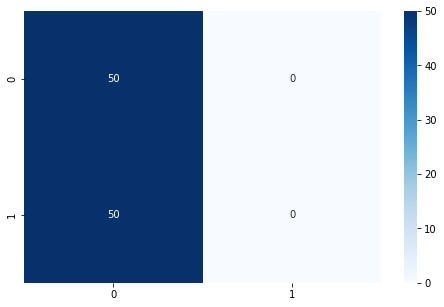

In [78]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_actual_eff,y_pred_eff)
import seaborn as sns
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat,annot=True,cmap="Blues")